In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn import linear_model

In [2]:
def plotCorrelationMatrix(df, graphWidth):
    df = df.dropna('columns') 
    df = df[[col for col in df if df[col].nunique() > 1]] 
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=100, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix', fontsize=15)
    plt.show()

### Brief Exploration of Dataset
With 851,264 samples and 501 unique ticker symbols, each ticker symbol has an average of almost 1,700 samples. Since there are no empty/null values in the dataset, we won't have to worry about null/empty values during preprocessing. Also, all the variables (except for stock volume) are highly correlated, so a change in one of these variables should represent a very similar change in the other (again, except for stock volume).

Number of samples: 851264
Number of unique ticker symbols: 501
Number of raw features: 7
  - Number of numerical variables: 5
  - Categorical variables: ['symbol', 'date']
  - Number of null/empty values: 0



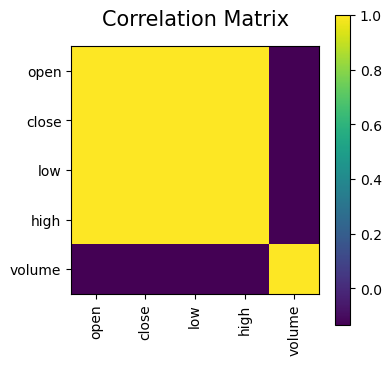

In [3]:
df = pd.read_csv("prices-split-adjusted.csv")
print(f'Number of samples: {df.shape[0]}')
print(f'Number of unique ticker symbols: {len(df["symbol"].unique())}')
print(f'Number of raw features: {df.shape[1]}')
print(f'  - Number of numerical variables: {len(df._get_numeric_data().columns)}')
print(f'  - Categorical variables: {list(set(df.columns) - set(df._get_numeric_data().columns))}')
print(f'  - Number of null/empty values: {np.shape(np.where(pd.isnull(df)))[1]}\n')
plotCorrelationMatrix(df, 4)

### Pre-processing and Feature Extraction of Dataset
The only preprocessing/feature extraction done is to standardize the closing stock prices before we extract the data for the specific ticker symbol.

In [4]:
def get_data(df, forecast_col, forecast_dist):
    forecast = df[forecast_col].shift(-forecast_dist)
    X = np.array(df[[forecast_col]])
    X = preprocessing.scale(X)
    X = X[:-forecast_dist]
    forecast = forecast.dropna()
    y = np.array(forecast)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
    return [X_train, X_test, y_train, y_test]

In [5]:
def euclidian_distance(arr1, arr2):
    sum = 0
    for i in range(len(arr1)):
        sum += np.square(arr1[i] - arr2[i])
    return np.sqrt(sum)

### Processing of Dataset
First, we extract the data for each specific ticker symbol using the `get_data()` function. Then, we process the data using the following three regression models. In order to allow for predictions and comparisons, the last 50 samples are removed, and will be predicted after the regressor model is fitted to the training data.
1. sklearn's Linear Regression model
 - Learn a linear equation to predict the future values
2. sklearn's Ridge Regression model with built in cross-validation
 - sklearn tries multiple alpha values and returns the regression model which uses the optimal one for the training data
 - Learns the model that predicts future values
3. sklearn's Lasso Regression model with built in cross-validation
 - sklearn tries multiple alpha values and returns the regression model which uses the optimal one for the training data
 - Learns the model that predicts future values

In [6]:
df_test_list = []
for ticker in df["symbol"].unique():
    df_ticker = df.loc[df["symbol"] == ticker]
    X_train, X_test, y_train, y_test = get_data(df_ticker, 'close', 50)
    df_ticker_test = pd.DataFrame(y_test, columns=["close"])
    
    model = linear_model.LinearRegression(fit_intercept=True, copy_X=True)
    model.fit(X_train, y_train)
    linear_predictions = model.predict(X_test)
    df_ticker_test['linear'] = linear_predictions
    
    model = linear_model.RidgeCV(fit_intercept=True)
    model.fit(X_train, y_train)
    ridge_predictions = model.predict(X_test)
    df_ticker_test['ridge'] = ridge_predictions
    
    model = linear_model.LassoCV(fit_intercept=True)
    model.fit(X_train, y_train)
    lasso_predictions = model.predict(X_test)
    df_ticker_test['lasso'] = lasso_predictions
    df_test_list.append(df_ticker_test)

### Comparative Analysis

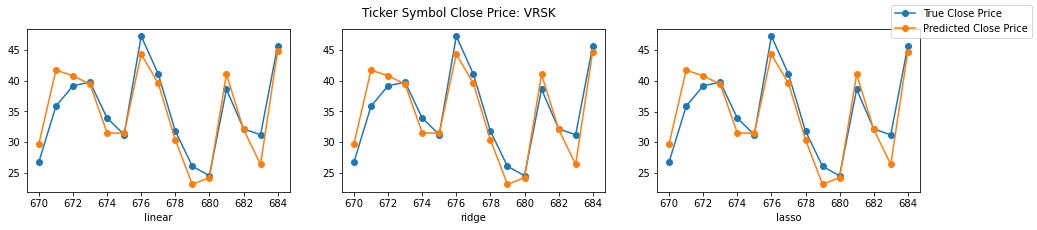

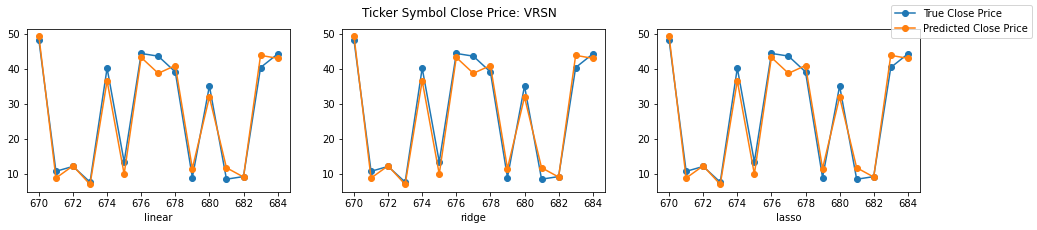

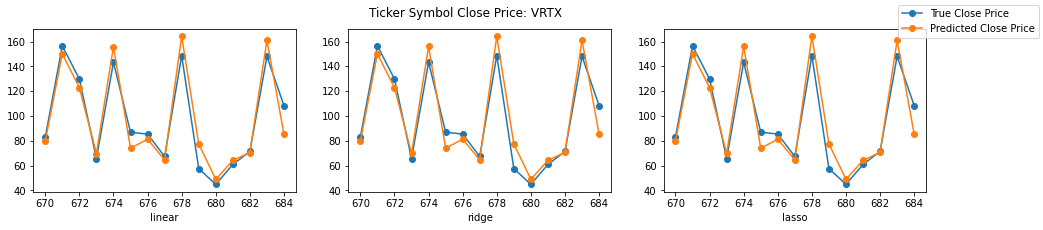

linear regression total loss: 127.6771
ridge regression total loss: 127.6783
lasso regression total loss: 127.6825


In [7]:
randomint = np.random.randint(0, len(df["symbol"].unique()) - 5)
regtype = ['linear', 'ridge', 'lasso']
for idx, ticker in enumerate(df["symbol"].unique()[randomint:randomint + 3]):
    df_ticker = df_test_list[idx]
    x = range(df_ticker.shape[0] - 15, df_ticker.shape[0])
    y_true = df_ticker['close'][df_ticker.shape[0] - 15:df_ticker.shape[0]]
    fig, axs = plt.subplots(1, 3, figsize=(16,3))
    for i, ax in enumerate(axs):
        y_pred = df_ticker[regtype[i]][df_ticker.shape[0] - 15:df_ticker.shape[0]]
        ax.plot(x, y_true, '-o', label="True Close Price")
        ax.plot(x, y_pred, '-o', label="Predicted Close Price")
        ax.set_xlabel(regtype[i])
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    fig.suptitle(f'Ticker Symbol Close Price: {ticker}', va='top')
    plt.show()

for reg in regtype:
    total_loss = 0
    for idx, ticker in enumerate(df["symbol"].unique()):
        df_ticker = df_test_list[idx]
        total_loss += euclidian_distance(df_ticker['close'], df_ticker[reg]) / df_ticker.shape[0]
    print(f'{reg} regression total loss: {total_loss:.4f}')

Visually, all three regression methods perform pretty similarly as is seen in the sample of 3 randomly chosen ticker symbols with graphs of their true closing price and predicted closing price. However, by comparing the results through a euclidian distance metric, the linear regression model performed the best, so it should be the regressor that goes into production for this dataset. However, since the total loss is so similar for each method, any of them could go into production with similar results.

### Ethical Issues
Parties looking to predict future stock prices should be cautious to immediately trust regression predictions as they cannot account for unexpected events that could occur. The predictions are only based on trends, and as such cannot predict changes caused by something like the COVID-19 affecting the stock market as a whole.

### Bibliography
Gawlik, Dominik. “New York Stock Exchange.” Kaggle, Google, 22 Feb. 2017, www.kaggle.com/dgawlik/nyse. 

N/A, N/A. “API Reference.” Scikit, Scikit-Learn Developers, 2020, scikit-learn.org/stable/modules/classes.html. 